In [22]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact
import seaborn as sns
from tqdm import tqdm

In [3]:
models = {
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "gonzalobenegas/gpn-brassicales": "repeat-weight-0.1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
}

d = Path("output/simulated_variants")
variants = pd.read_csv(
    d / "variants.annotated.vcf.gz", sep="\t", header=None, comment="#",
    usecols=[0,1,3,4,7], dtype={0: str},
).rename(columns={0: 'chrom', 1: 'pos', 3: 'ref', 4: 'alt', 7: "INFO"})
variants["consequence"] = variants.INFO.str.replace(
    "CSQ=", ""
).str.split(",").apply(
    lambda x: ",".join(sorted(list(set([y.split("|")[1] for y in x]))))
).drop(columns="INFO")

for m, n in models.items():
    variants[n] = pd.read_parquet(d / "vep" / (m + ".parquet")).score.values
variants

,chrom,pos,ref,alt,INFO,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0
0,5,3500000,G,A,CSQ=A|synonymous_variant|LOW|TRS120|AT5G11040|...,synonymous_variant,-0.371572,-0.306620,-0.228212
1,5,3500000,G,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.173257,-1.040644,-1.636478
2,5,3500000,G,T,CSQ=T|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.769428,-1.525826,-1.743758
3,5,3500001,A,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-2.236280,-1.936424,-1.556498
4,5,3500001,A,G,CSQ=G|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-0.308526,0.131796,-0.238257
...,...,...,...,...,...,...,...,...,...
2999995,5,4499998,C,G,CSQ=G|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.334870,0.895628,1.199073
2999996,5,4499998,C,T,CSQ=T|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.402710,0.305114,0.770390
2999997,5,4499999,G,A,CSQ=A|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.027268,-0.686044,-0.496679
2999998,5,4499999,G,C,CSQ=C|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.360318,0.997256,1.561297


In [4]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
variants["start"] = variants.pos
variants["end"] = variants.start + 1
variants = bf.coverage(variants, repeats).rename(columns={"coverage": "repeat"})
variants.repeat = variants.repeat.astype(bool)
variants

,chrom,pos,ref,alt,INFO,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,start,end,repeat
0,5,3500000,G,A,CSQ=A|synonymous_variant|LOW|TRS120|AT5G11040|...,synonymous_variant,-0.371572,-0.306620,-0.228212,3500000,3500001,False
1,5,3500000,G,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.173257,-1.040644,-1.636478,3500000,3500001,False
2,5,3500000,G,T,CSQ=T|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.769428,-1.525826,-1.743758,3500000,3500001,False
3,5,3500001,A,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-2.236280,-1.936424,-1.556498,3500001,3500002,False
4,5,3500001,A,G,CSQ=G|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-0.308526,0.131796,-0.238257,3500001,3500002,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,5,4499998,C,G,CSQ=G|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.334870,0.895628,1.199073,4499998,4499999,False
2999996,5,4499998,C,T,CSQ=T|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.402710,0.305114,0.770390,4499998,4499999,False
2999997,5,4499999,G,A,CSQ=A|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.027268,-0.686044,-0.496679,4499999,4500000,False
2999998,5,4499999,G,C,CSQ=C|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.360318,0.997256,1.561297,4499999,4500000,False


In [5]:
variants.consequence = variants.consequence.str.replace("_variant", "")

variants.loc[variants["repeat"], "consequence"] = "repeat"

#variants.loc[((variants["repeat"] & (variants.consequence=="intergenic"))), "consequence"] = "intergenic_repeat"
#variants.consequence.replace("intergenic", "intergenic_non_repeat", inplace=True)

variants.consequence.replace("non_coding_transcript_exon", "nc_transcript_exon", inplace=True)

In [12]:
results = []
for m in models.values():
    threshold = variants.query('consequence == "missense"')[m].quantile(0.1)
    score = variants.query('consequence == "repeat"')[m]
    results.append([m, (score < threshold).sum(), (score >= threshold).sum()])
results = pd.DataFrame(results, columns=["Model", "Below", "Above"])
results

,Model,Below,Above
0,repeat-weight-1,29547,78183
1,repeat-weight-0.1,10175,97555
2,repeat-weight-0,8878,98852


In [39]:
col_name = "% repeat scored lower\nthan missense 1st decile"
results[col_name] = (results.Below / (results.Below + results.Above)) * 100
results

,Model,Below,Above,% repeat scored lower than missense 1st decile,% repeat scored lower\nthan missense 1st decile
0,repeat-weight-1,29547,78183,0.274269,27.426901
1,repeat-weight-0.1,10175,97555,0.094449,9.444909
2,repeat-weight-0,8878,98852,0.082410,8.240973


In [40]:
for m in models.values():
    if m == "repeat-weight-1": continue
    counts = results.set_index("Model").loc[[m, "repeat-weight-1"], ["Below", "Above"]]
    odds_ratio, p_value = fisher_exact(counts, alternative='less')
    print(m, p_value)

repeat-weight-0.1 0.0
repeat-weight-0 0.0


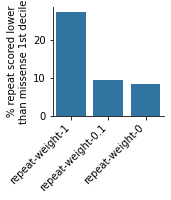

In [45]:
plt.figure(figsize=(2,2))
g = sns.barplot(data=results, x="Model", y=col_name, color="C0")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
sns.despine()
plt.xlabel("")
plt.savefig("output/plots/vep_simulated_comparison.svg", bbox_inches="tight")